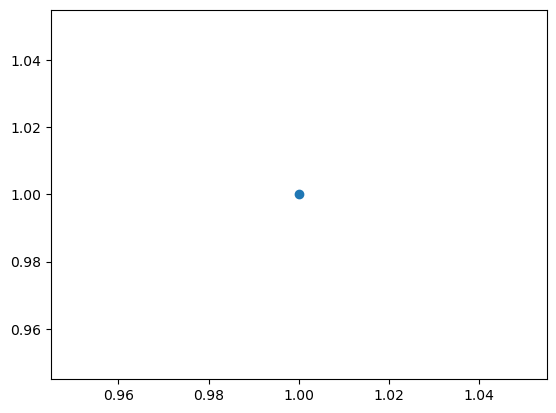

In [1]:
import matplotlib.pyplot as plt
plt.scatter(1,1)

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import numpy as np

In [3]:
main_dir = 'datasets'
set_dir = 'convencoderset'
train_dir = 'train'
test_dir = 'test'

In [4]:
train_transforms = transforms.Compose([
                                       transforms.Resize((128, 128)),
                                       transforms.ToTensor()
                                      ])
test_transforms = train_transforms

TRAIN_DATA = datasets.ImageFolder(os.path.join(main_dir, set_dir, train_dir), transform=train_transforms)
TEST_DATA = datasets.ImageFolder(os.path.join(main_dir, set_dir, test_dir), transform=test_transforms)

In [25]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d(2, 2)
        self.sample = nn.Upsample(scale_factor=2, mode='nearest')

        n = 6
        
        self.conv1_minus = nn.Conv2d(3, n, kernel_size=5, stride=1, padding=2)
        self.conv2_minus = nn.Conv2d(n, n, kernel_size=5, stride=1, padding=2)
        self.conv3_minus = nn.Conv2d(n, n, kernel_size=5, stride=1, padding=2)
        self.conv4_minus = nn.Conv2d(n, n, kernel_size=5, stride=1, padding=2)
        self.bn6 = nn.BatchNorm2d(n)
        
        self.conv_bottleneck = nn.Conv2d(n, n, kernel_size=1, stride=1, padding=0)
        
        self.conv1_plus = nn.Conv2d(n, n, kernel_size=5, stride=1, padding=2)
        self.conv2_plus = nn.Conv2d(n, n, kernel_size=5, stride=1, padding=2)
        self.conv3_plus = nn.Conv2d(n, n, kernel_size=5, stride=1, padding=2)
        self.conv4_plus = nn.Conv2d(n, 3, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(3)
        
    def forward(self, X):
        
        X = self.conv1_minus(X)      
        X = self.bn6(X)
        X = F.relu(X)
        X = F.dropout2d(X, p=0.99)
        #X = self.pool(X)

        X = self.conv2_minus(X)      
        X = self.bn6(X)
        X = F.relu(X)
        X = F.dropout2d(X, p=0.99)
        X = self.pool(X)

        X = self.conv3_minus(X)      
        X = self.bn6(X)
        X = F.relu(X)
        X = F.dropout2d(X, p=0.99)
        #X = self.pool(X)
        
        X = self.conv4_minus(X)      
        X = self.bn6(X)
        X = F.relu(X)
        X = F.dropout2d(X, p=0.99)
        X = self.pool(X)
        

        X = self.conv_bottleneck(X)
        X = F.relu(X)

        X = self.sample(X)
        
        X = self.conv1_plus(X)
        X = self.bn6(X)
        X = F.relu(X)

        #X = self.sample(X)
        
        X = self.conv2_plus(X)
        X = self.bn6(X)
        X = F.relu(X)
        
        X = self.sample(X)
        
        X = self.conv3_plus(X)
        X = self.bn6(X)
        X = F.relu(X)

        #X = self.sample(X)
        
        X = self.conv4_plus(X)
        X = self.bn3(X)
        X = F.relu(X)

        return X

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
epoche = 0

In [35]:
epochs = 100000
learning_rate = 0.0001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=0.0001)

BATCH_SIZE = 8#len(TEST_DATA)
           
train_loader = torch.utils.data.DataLoader(TRAIN_DATA, batch_size= BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(TEST_DATA, batch_size= BATCH_SIZE, shuffle=False)

In [ ]:
for cur in range(epochs):
    epoche += 1 
    
    for x, _ in train_loader:
        inputs, labels = x.to(device), x.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
         
        loss = criterion(outputs, labels)
    
        loss.backward()
        optimizer.step()
    
        print(f"Эпоха: {epoche} , ошибка  {loss}",
              sep='', end='\r')

<Figure size 640x480 with 0 Axes>

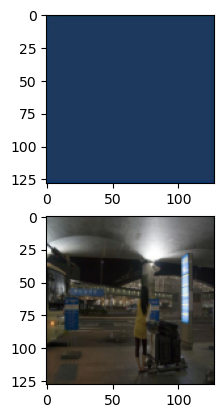

In [34]:
plt.figure()
model.eval()
f, axarr = plt.subplots(2,1)
source = TRAIN_DATA
inp = source[np.random.randint(0, len(source))][0]
ans = model(inp.unsqueeze(0).to(device)).cpu().detach()
ans = np.array(ans.view(3,128,128)).transpose((1, 2, 0))
axarr[0].imshow(ans)
axarr[1].imshow(np.array(inp.view(3,128,128)).transpose((1, 2, 0)))